# SDSC3001 - Course Project

## Jaccard similarity coefficient

In [1]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)


# Example usage
set1 = {"a", "b", "c", "d"}
set2 = {"c", "d", "e", "f"}

similarity = jaccard_similarity(set1, set2)
print(f"Jaccard Similarity: {similarity}")

Jaccard Similarity: 0.3333333333333333


## Sketching techniques for the Jaccard similarity coefficient

In [2]:
import numpy as np
import random


random_seed = 42
random.seed(random_seed)
# Parameters
k = 128  # Number of hash functions
n = 10_000  # cardinality of the sets

In [3]:
import sys
import os

# print(os.getcwd() in sys.path)
sys.path.append(os.getcwd())
# print(os.getcwd() in sys.path)

In [4]:
from hashSketch import MinHash, B_bitMinHash, OddSketch, MaxLogHash

## Datasets

### Synthetic datasets

Generate set A by randomly selecting n different numbers from I

Generate set B by randomly selecting $|A \cup B| = \frac{J_{A, B}|A|}{1+J_{A, B}}$ different numbers from set A and $n - |A \cup B|$ different numbers from set I\A

n = 10,000 by default

- Balanced set-pairs (i.e., |A| = |B| = n)
- Unbalanced set-pairs (i.e., |A| != |B|)

In [5]:
# syntheticDataset.py
def compare_all_methods(stream, num_runs, k=128, n=10000): ...

In [6]:
import polars as pl


df_balance_mean = pl.read_parquet("result/balanced_mean_results.parquet")
df_balance_median = pl.read_parquet("result/balanced_median_results.parquet")
df_balance_std = pl.read_parquet("result/balanced_std_results.parquet")
df_balance_rmse = pl.read_parquet("result/balanced_rmse_results.parquet")
df_balance_bias = pl.read_parquet("result/balanced_bias_results.parquet")

df_unbalance_mean = pl.read_parquet("result/unbalance_mean_results.parquest")
df_unbalance_median = pl.read_parquet("result/unbalance_median_results.parquest")
df_unbalance_std = pl.read_parquet("result/unbalance_std_results.parquest")
df_unbalance_rmse = pl.read_parquet("result/unbalance_rmse_results.parquest")
df_unbalance_bias = pl.read_parquet("result/unbalance_bias_results.parquest")

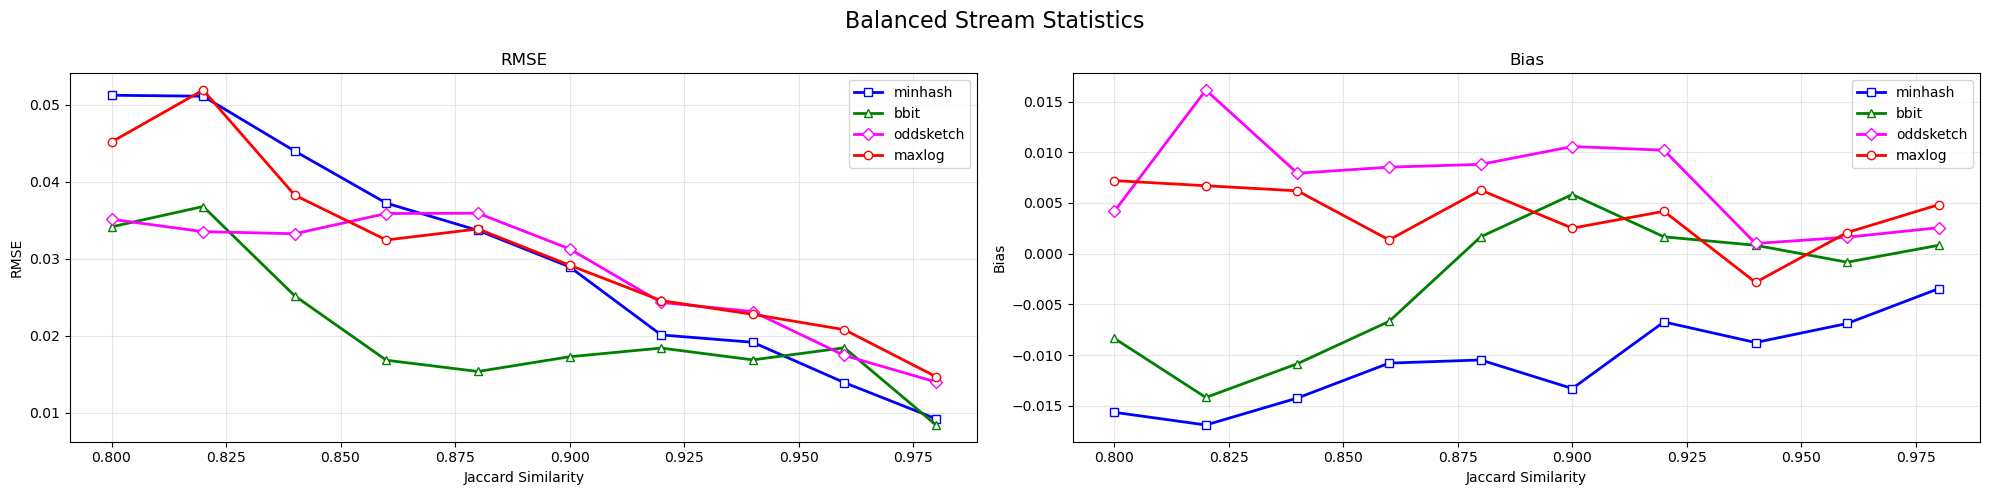

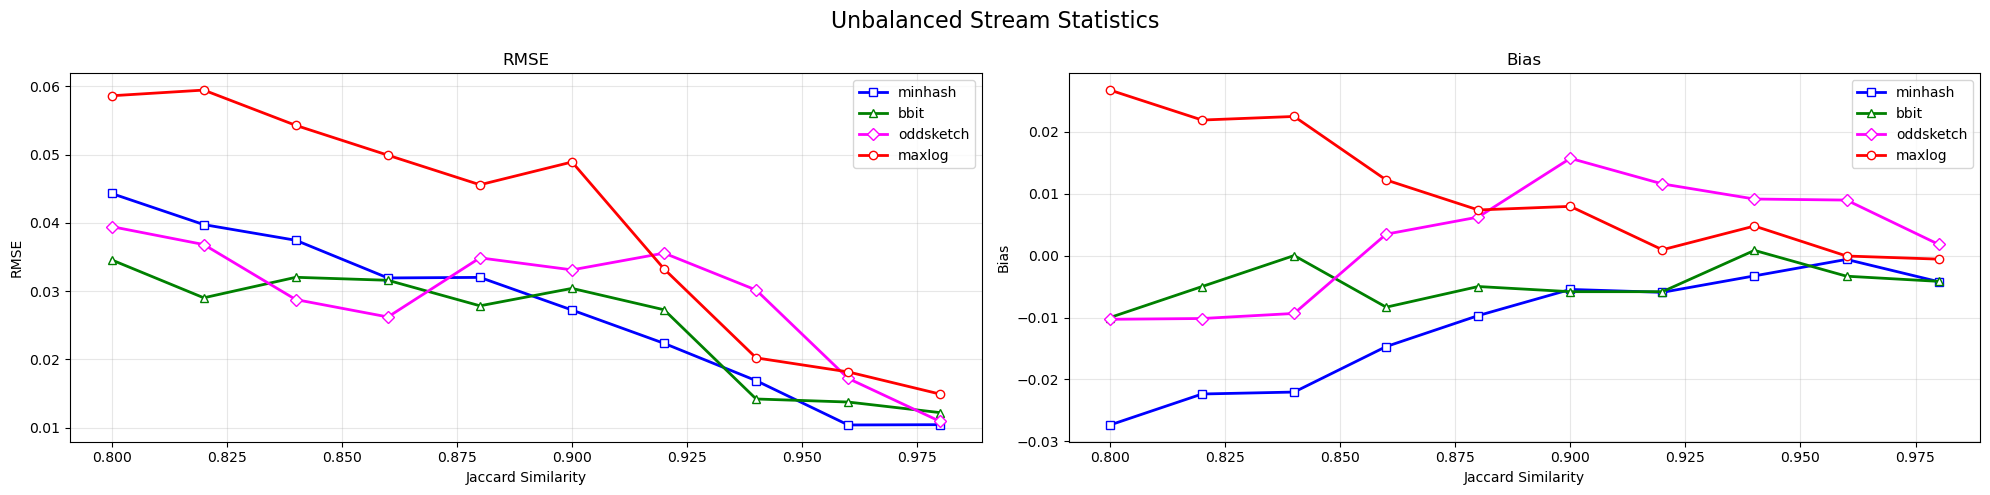

In [7]:
import matplotlib.pyplot as plt


def plot_stream_stats(title, df_mean, df_median, df_std, df_rmse, df_bias):
    # fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Data to plot
    # dfs = [df_mean, df_median, df_std, df_rmse, df_bias]
    # titles = ["Mean", "Median", "Standard Deviation", "RMSE", "Bias"]
    dfs = [df_rmse, df_bias]
    titles = ["RMSE", "Bias"]

    # Colors and markers for different methods
    methods = ["minhash", "bbit", "oddsketch", "maxlog"]
    colors = ["blue", "green", "magenta", "red"]
    markers = ["s", "^", "D", "o"]

    for idx, (df, title) in enumerate(zip(dfs, titles)):
        ax = axes[idx]

        # Plot each method
        for method, color, marker in zip(methods, colors, markers):
            ax.plot(
                df["jaccard"],
                df[method],
                color=color,
                marker=marker,
                label=method,
                markersize=6,
                linewidth=2,
                markerfacecolor="white",
            )

        ax.set_xlabel("Jaccard Similarity")
        ax.set_ylabel(title)
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_title(f"{title}")

    plt.tight_layout()
    return fig


# Plot balanced stream statistics
fig1 = plot_stream_stats(
    "Balanced Stream Statistics",
    df_balance_mean,
    df_balance_median,
    df_balance_std,
    df_balance_rmse,
    df_balance_bias,
)

# Plot unbalanced stream statistics
fig2 = plot_stream_stats(
    "Unbalanced Stream Statistics",
    df_unbalance_mean,
    df_unbalance_median,
    df_unbalance_std,
    df_unbalance_rmse,
    df_unbalance_bias,
)

fig1.savefig("figures/balanced_stats.png", dpi=300, bbox_inches="tight")
fig2.savefig("figures/unbalanced_stats.png", dpi=300, bbox_inches="tight")

plt.show()

### Real-world datasets

In [8]:
def load_dataset_as_stream(filepath):
    stream = []
    with open(filepath, "r") as file:
        for record_id, line in enumerate(file):
            items = [int(x) for x in line.strip().split()]
            for item in items:
                stream.append([record_id, item])

    return stream


def load_dataset_as_records(filepath):
    records = []
    with open(filepath, "r") as file:
        for record_id, line in enumerate(file):
            items = [int(x) for x in line.strip().split()]
            records.append((record_id, items))

    return records


def load_dataset_as_dataframe(filepath):
    with open(filepath, "r") as file:
        dataset = pl.DataFrame(np.loadtxt(file, dtype=int))

    item_record_pairs = {}
    for record_id, record in enumerate(dataset):
        for item in record:
            if item not in item_record_pairs:
                item_record_pairs[item] = []
            item_record_pairs[item].append(record_id)
    pairs = [(item, rec) for item, recs in item_record_pairs.items() for rec in recs]
    print(dataset.head(5))
    print(f"{dataset.shape[0]} records with {len(item_record_pairs)} distinct times")
    print(f"{len(pairs)} item-record pairs")

    return dataset

#### MUSHROOM dataset

- 8,124 records with 119 distinct items
- 186,852 item-record pairs

In [9]:
mushroom_dataset_path = "./data/mushroom.dat"
mushroom_stream = load_dataset_as_stream(mushroom_dataset_path)
mushroom_records = load_dataset_as_records(mushroom_dataset_path)

In [10]:
minhash = MinHash(k)
bbit_minhash = B_bitMinHash(k, b=4)
odd_sketch = OddSketch(k, z=4 * k)
maxlog = MaxLogHash(k)

In [11]:
from itertools import combinations


def compare_all_methods_readworld(stream, records, num_pairs=1000, k=128):
    """
    Analyze sampled pairs from mushroom dataset using different sketching techniques

    Args:
        stream: List of [record_id, item] pairs
        num_pairs: Number of record pairs to sample
        k: Number of hash functions

    Returns:
        polars.DataFrame: Results containing similarity estimates for each method
    """
    # Get unique record IDs
    record_ids = list(set(pair[0] for pair in stream))

    # Sample random pairs of records
    random_pairs = random.sample(list(combinations(record_ids, 2)), num_pairs)

    # Initialize sketches
    minhash = MinHash(k)
    bbit_minhash = B_bitMinHash(k, b=4)
    odd_sketch = OddSketch(k, z=4 * k)
    maxlog = MaxLogHash(k)

    # Process stream for each sketch method
    for sketch in [minhash, bbit_minhash, odd_sketch, maxlog]:
        sketch.process_stream(stream)

    # Collect results
    results = []
    for record1, record2 in random_pairs:
        true_similarity = jaccard_similarity(set(records[record1][1]), set(records[record2][1]))

        pair_results = {
            "record1": record1,
            "record2": record2,
            "true_jaccard": true_similarity,
            "minhash": minhash.estimate_similarity(record1, record2),
            "bbit": bbit_minhash.estimate_similarity(record1, record2),
            "oddsketch": odd_sketch.estimate_similarity(record1, record2),
            "maxlog": maxlog.estimate_similarity(record1, record2),
        }
        results.append(pair_results)

    # Create DataFrame
    df = pl.DataFrame(results)

    return df


In [12]:
# # Analyze sampled pairs
# results_df = compare_all_methods_readworld(mushroom_stream, mushroom_records, num_pairs=1000)
# # Save results
# results_df.write_parquet("result/mushroom_pair_results.parquet")

# or load results
results_df = pl.read_parquet("result/mushroom_pair_results.parquet")

results_df.head()

record1,record2,true_jaccard,minhash,bbit,oddsketch,maxlog
i64,i64,f64,f64,f64,f64,f64
3319,4907,0.314286,0.2578125,0.241667,0.225507,0.339301
473,5573,0.179487,0.109375,0.2,0.191021,0.230989
103,7909,0.314286,0.3046875,0.283333,0.322357,0.339301
4095,5181,0.4375,0.34375,0.358333,0.322357,0.566754
1228,8015,0.277778,0.2578125,0.216667,0.291104,0.328469


In [13]:
def analyze_all_methods_realword(dataframe):
    # Calculate statistics
    dataframe = dataframe.with_columns(
        (dataframe["true_jaccard"] - dataframe["minhash"]).alias("minhash_error"),
        (dataframe["true_jaccard"] - dataframe["bbit"]).alias("bbit_error"),
        (dataframe["true_jaccard"] - dataframe["oddsketch"]).alias("oddsketch_error"),
        (dataframe["true_jaccard"] - dataframe["maxlog"]).alias("maxlog_error"),
    )
    stats = {
        "method": ["minhash", "bbit", "oddsketch", "maxlog"],
        "mean": [
            dataframe["minhash"].mean(),
            dataframe["bbit"].mean(),
            dataframe["oddsketch"].mean(),
            dataframe["maxlog"].mean(),
        ],
        "median": [
            dataframe["minhash"].median(),
            dataframe["bbit"].median(),
            dataframe["oddsketch"].median(),
            dataframe["maxlog"].median(),
        ],
        "std": [
            dataframe["minhash"].std(),
            dataframe["bbit"].std(),
            dataframe["oddsketch"].std(),
            dataframe["maxlog"].std(),
        ],
        "rmse": [
            (dataframe["minhash_error"] ** 2).mean() ** 0.5,
            (dataframe["bbit_error"] ** 2).mean() ** 0.5,
            (dataframe["oddsketch_error"] ** 2).mean() ** 0.5,
            (dataframe["maxlog_error"] ** 2).mean() ** 0.5,
        ],
        "bias": [
            dataframe["minhash_error"].mean(),
            dataframe["bbit_error"].mean(),
            dataframe["oddsketch_error"].mean(),
            dataframe["maxlog_error"].mean(),
        ],
    }

    stats_df = pl.DataFrame(stats)

    return stats_df

In [14]:
# Save results
stats_df = analyze_all_methods_realword(results_df)

# or load results
# stats_df.write_parquet("result/mushroom_stats_results.parquet")

In [15]:
print(stats_df)

shape: (4, 6)
┌───────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ method    ┆ mean     ┆ median   ┆ std      ┆ rmse     ┆ bias      │
│ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ str       ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ minhash   ┆ 0.292648 ┆ 0.25     ┆ 0.166855 ┆ 0.058571 ┆ 0.044202  │
│ bbit      ┆ 0.331533 ┆ 0.291667 ┆ 0.159565 ┆ 0.03919  ┆ 0.005318  │
│ oddsketch ┆ 0.344002 ┆ 0.306853 ┆ 0.171544 ┆ 0.065526 ┆ -0.007151 │
│ maxlog    ┆ 0.393489 ┆ 0.350132 ┆ 0.149196 ┆ 0.083587 ┆ -0.056638 │
└───────────┴──────────┴──────────┴──────────┴──────────┴───────────┘


#### CONNECT dataset

- 67,557 records with 127 distinct items
- 2,904,951 item-record pairs

In [16]:
connect_dataset_path = "./data/connect.dat"
connect_stream = load_dataset_as_stream(connect_dataset_path)